# K-Random-Neighbors

In [71]:
import pandas as pd
from sklearn.utils.extmath import weighted_mode
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import numpy as np
import time
from sklearn.datasets import load_digits
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from itertools import combinations
import multiprocessing
from joblib import Parallel, delayed


## K-Random-Neighbors

In [72]:
class KRandomNeighbors:
    
    def __init__(self):
        self.fit_map = None
        self.stddev = None
        self.X_shape = None
        self.XTrain_view = None
        self.YTrain = None
        self.stddev_target_scaler = 0.5
        
    def scaled_sigmoid(self, x, a, b, c):
        return a / (1 + np.exp(c * (x - b)))
    
    def fit(self, XTrain: np.ndarray, YTrain: np.ndarray):
        self.YTrain = YTrain
        
        # create a hashmap with feature tuples as keys and target values as values
        self.fit_map = {tuple(x): y for x, y in zip(XTrain, YTrain)}
        
        # compute the standard deviation for each column in XTrain
        self.stddev = np.std(XTrain, axis=0)
        
        # store the shape of the training data
        self.X_shape = XTrain.shape
        
        # convert the training data of shape n*m into an ndarray of shape n*1 with tuple-like elements of form 1*m
        XTrain = np.ascontiguousarray(XTrain)
        self.XTrain_view = XTrain.view([('', XTrain.dtype)] * XTrain.shape[1])
        
        # TODO: optimize stddev_target_scaler
        
    def predict(self, X, k, num_points=1000, print_shots="no"):
        hits = list()
        
        while len(hits) < k:
            # generate data points
            rng = np.random.default_rng()
            shot_shape = (num_points, self.X_shape[1])
            points: np.ndarray = rng.normal(X, self.stddev /2 , size=shot_shape).round(1)
            
            # convert points into structured arrays (treat rows as tuples)
            point_view = points.view([('', points.dtype)] * points.shape[1])
            
            # determine the intersection between generated points and training data
            intersection: np.ndarray = np.intersect1d(self.XTrain_view, point_view)
            if (print_shots == "yes"):
                print(points[0, :], end='\r', flush=True)
            
            if intersection.shape[0] > 0:
                hits.extend(intersection.tolist())
                
        # determine class for each hit
        classes = list()
        for hit in hits:
            classes.append(self.fit_map[hit])
            
        classes = np.array(classes)
        
        # TODO: assign weights for each hit, use scaled_sigmoid(), to accomplish this
        weights = np.ones(shape=classes.shape)
        
        # determine the mode (most frequently occurring class)
        prediction = weighted_mode(classes, weights)
        
        return prediction[0][0].astype(int)
    
    
    def test(self, XTest: np.ndarray, YTest: np.ndarray, k:int = 11) -> tuple[float | np.ndarray, float | np.ndarray, float | np.ndarray, np.ndarray | None]:
        predictions = list()
        
        
        for i in range(XTest.shape[0]):
            prediction = self.predict(XTest[i], k)
            predictions.append(prediction)
        
        classes = np.unique(np.concatenate([YTest, self.YTrain]))
        return precision_recall_fscore_support(YTest, predictions, labels=classes, zero_division=0)
            
            
            
        


# k-random-enseble

In [73]:
class KRandomEnsable:
    
    def __init__(self, combined_features=4, weight_strategy="f1"):
        self.COMBINED_FEATURES = combined_features
        self.weight_strategy = weight_strategy  # e.g. "precision", "recall", "f1", "uniform"
        self.WORKERS:list[tuple[KRandomNeighbors, float, np.ndarray]] = []

        
    def get_feature_combinations(self, dims):
        # make sure that feature combinations are not longer than existing features
        if (dims < self.COMBINED_FEATURES):
            self.COMBINED_FEATURES = dims
        elif (dims == self.COMBINED_FEATURES):
            self.COMBINED_FEATURES -= 1
        
        # get idx of all features
        feature_idxs = list(range(dims))
        
        # get all combinations of Features
        return np.array(list(combinations(feature_idxs, self.COMBINED_FEATURES)))
    
    
    def fit(self, XTrain: np.ndarray, YTrain: np.ndarray, XTest: np.ndarray, YTest: np.ndarray):
        # get possible combinations of features
        combs = self.get_feature_combinations(XTrain.shape[1])
        
        # decide how many workers schould be used -> use as many combinations as there are cores, unless there are more cores than combinations
        worker_count = min(multiprocessing.cpu_count(), combs.shape[0])
        
        # choose the combinations on which the workers are trained on
        rng = np.random.default_rng()
        comb_idxs = rng.choice(combs.shape[0], worker_count, replace=False)
        combs = combs[comb_idxs]
        
        # train each worker with one combination
        for current_combo in combs:            
            # generate training dataset by using only the features at the given idxs in the current combination
            X_subset = XTrain[:, current_combo]
            
            # create and Train worker
            worker:KRandomNeighbors = KRandomNeighbors()
            worker.fit(X_subset, YTrain)
            
            # evaluate trusworthyness of the worker
            (precision, recall, fscore, support) = worker.test(XTest[:, current_combo], YTest)
            
            # weight according to strategie
            weight = self.get_weight(precision, recall, fscore)
                
            self.WORKERS.append((worker, weight, np.array(current_combo)))

    def get_weight(self, precision, recall, fscore):
        weight = 1
        if self.weight_strategy == "precision":
            weight = np.mean(precision)
        elif self.weight_strategy == "recall":
            weight = np.mean(recall)
        elif self.weight_strategy == "f1":
            weight= np.mean(fscore)
        else:  # uniform
            weight = 1.0
        return weight
    
    def _predict_worker(self, worker: KRandomNeighbors, weight: float, x_subset: np.ndarray, k: int):
        pred = worker.predict(x_subset, k=k)
        return pred, weight

    
    def predict(self, X: np.ndarray):
        predictions = []
        
        for i in range(X.shape[0]):
            results = Parallel(n_jobs=-1)(
                delayed(self._predict_worker)(worker, weight, X[i][feature_idxs], k=11)
                for worker, weight, feature_idxs in self.WORKERS
            )
            
            votes, weights = zip(*results)
            votes = np.array(votes)
            weights = np.array(weights)
            
            final_pred = weighted_mode(votes, w=weights)[0][0]
            predictions.append(final_pred)
            
        return np.array(predictions)
        
        

## Test funktion

In [74]:
def test_krn(XTrain: np.ndarray, YTrain: np.ndarray, XTest: np.ndarray, YTest: np.ndarray, k=11, do_print = "none"):
    """
    Evaluates a KRandomNeighbors model on a given test set and optionally prints detailed metrics.

    Trains a KRandomNeighbors model on the provided training set and evaluates it on the test set.
    Computes predictions, confusion matrix, precision, recall, F1-score, and timing information.

    Parameters:
    ----------
    XTrain : np.ndarray
        Feature matrix for training data.
    YTrain : np.ndarray
        Labels for training data.
    XTest : np.ndarray
        Feature matrix for test data.
    YTest : np.ndarray
        Labels for test data.
    k : int, optional (default=11)
        Number of nearest neighbors to consider during prediction.
    do_print : str, optional (default="none")
        Controls output verbosity:
        - "none": no output
        - "metrics": print confusion matrix and evaluation metrics
        - "all": also print individual predictions and their computation time

    Returns:
    -------
    cm : np.ndarray
        Confusion matrix.
    precision : np.ndarray
        Precision score per class.
    recall : np.ndarray
        Recall score per class.
    f1 : np.ndarray
        F1-score per class.
    support : np.ndarray
        Number of true instances per class in the test set.
    total_time : float
        Total time taken for the entire test run (in seconds).
    time_per_prediction : float
        Average time per prediction (in seconds).
    time_per_feature : float
        Average prediction time per feature (in seconds).
    """
    # 1) Train the KNN
    krn = KRandomNeighbors()
    krn.fit(XTrain, YTrain)
    
    # Time measurement: Total time
    start_total = time.time()

    # 2) Predictions for all test samples
    predictions = []
    total_prediction_time = 0
    pshots = "yes" if do_print=="all" else "no"

    for i in range(XTest.shape[0]):
        start_pred = time.time()
        pred = krn.predict(XTest[i], 11, print_shots=pshots)
        end_pred = time.time()

        predictions.append(pred)
        
        pred_time = end_pred - start_pred
        total_prediction_time += pred_time
        
        if(do_print == "all"):
            print(f"Predicted class {pred} for {XTest[i]} in {round(pred_time, 3)} sec")
    
    end_total = time.time()

    # get all classes
    classes = np.unique(np.concatenate([YTrain, YTest]))

    # 3) Confusion matrix
    cm = confusion_matrix(YTest, predictions, labels=classes)
    
    if (do_print == "metrics" or do_print == "all"):
        print("Confusion Matrix:\n", cm)

    # 4) Precision, Recall, F1-score
    precision, recall, f1, support = precision_recall_fscore_support(
        YTest, predictions, labels=classes, zero_division=0
    )
    
    if (do_print == "metrics" or do_print == "all"):
        print("\nMetrics per class:")
        for idx, label in enumerate(classes):
            print(f"Class {label}:")
            print(f"  Precision: {precision[idx]:.2f}")
            print(f"  Recall:    {recall[idx]:.2f}")
            print(f"  F1-Score:  {f1[idx]:.2f}")
            print(f"  Support:   {support[idx]} samples\n")
        
    # Average time per prediction
    avg_prediction_time = total_prediction_time / XTest.shape[0]

    # Time per feature
    num_features = XTest.shape[1]
    avg_time_per_feature = avg_prediction_time / num_features

    total_time = round(end_total - start_total, 3)
    time_per_prediction = round(avg_prediction_time, 3)
    time_per_feature = round(avg_time_per_feature, 3)
    if (do_print == "metrics" or do_print == "all"):
        print("Total time:", total_time, "seconds")
        print("Avg. time per prediction:", time_per_prediction, "seconds")
        print("Avg. time per feature:", time_per_feature, "seconds")

    return cm, precision, recall, f1, support, total_time, time_per_prediction, time_per_feature


## Test: K-Random-Neighbors

In [75]:
%load_ext line_profiler

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler


In [76]:
# load the numeric data as an ndarray
dataset = np.loadtxt('iris_numeric.csv', delimiter=',')
# dataset = np.loadtxt('iris_synthetic.csv', delimiter=',')
# dataset = np.loadtxt('banknotes_numeric.csv', delimiter=',')

# select features and target data
X = dataset[:, :-1]  # all columns except the last
Y = dataset[:, -1]   # last column is the class/label

allIdx = np.arange(X.shape[0])  # all indices of the data

# randomly choose 75% of the indices for training
rng = np.random.default_rng()
tests = dict()

results = []

for i in range(60, 61, 10):
    train_idx = rng.choice(allIdx, size=int(allIdx.shape[0] * 0.75), replace=False)
    # train_idx = rng.choice(allIdx, size=i, replace=False)
    test_idx = np.delete(allIdx, train_idx)  # remaining for testing
    # test_idx = rng.choice(test_idx, size=100, replace=False)

    XTrain = X[train_idx]
    YTrain = Y[train_idx]

    XTest = X[test_idx]
    YTest = Y[test_idx]


    # %lprun -f KRandomNeighbors.predict test_knn(XTrain, YTrain, XTest, YTest, k=11)

    # Run KNN test and store result
    cm, precision, recall, f1, support, total_time, time_per_prediction, time_per_feature = test_krn(
        XTrain, YTrain, XTest, YTest, k=11, do_print="all"
    )

    results.append({
        "train_size": i,
        "total_time": total_time,
        "time_per_prediction": time_per_prediction,
        "time_per_feature": time_per_feature
    })

    print(f"Train size: {i}, time(s): {[total_time, time_per_prediction, time_per_feature]}")

# Als DataFrame speichern
df_results = pd.DataFrame(results)

# Als CSV exportieren
# df_results.to_csv("knn_runtime_results.csv", index=False)

Predicted class 0 for [5.1 3.5 1.4 0.2] in 0.018 sec
Predicted class 0 for [4.6 3.1 1.5 0.2] in 0.024 sec
Predicted class 0 for [5.  3.6 1.4 0.2] in 0.024 sec
Predicted class 0 for [4.8 3.  1.4 0.1] in 0.022 sec
Predicted class 0 for [5.8 4.  1.2 0.2] in 0.108 sec
Predicted class 0 for [5.4 3.9 1.3 0.4] in 0.063 sec
Predicted class 0 for [5.1 3.8 1.5 0.3] in 0.034 sec
Predicted class 0 for [5.1 3.3 1.7 0.5] in 0.018 sec
Predicted class 0 for [4.8 3.4 1.9 0.2] in 0.027 sec
Predicted class 0 for [5.5 4.2 1.4 0.2] in 0.115 sec
Predicted class 0 for [4.9 3.1 1.5 0.1] in 0.022 sec
Predicted class 0 for [4.8 3.  1.4 0.3] in 0.032 sec
Predicted class 0 for [5.3 3.7 1.5 0.2] in 0.025 sec
Predicted class 1 for [5.9 3.  4.2 1.5] in 0.029 sec
Predicted class 1 for [6.1 2.9 4.7 1.4] in 0.014 sec
Predicted class 1 for [6.7 3.1 4.4 1.4] in 0.034 sec
Predicted class 1 for [5.6 2.5 3.9 1.1] in 0.037 sec
Predicted class 1 for [5.9 3.2 4.8 1.8] in 0.06 sec
Predicted class 1 for [6.1 2.8 4.7 1.2] in 0.03

## Plot time per prediction

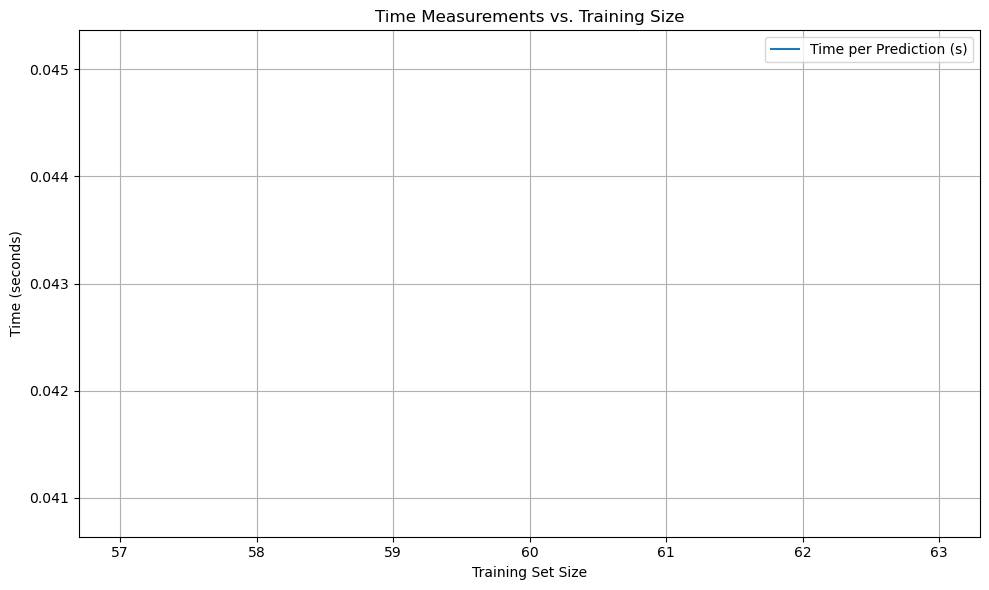

In [77]:
import matplotlib.pyplot as plt

# Load CSV if not already in memory
# df_results = pd.read_csv("knn_runtime_results.csv")

plt.figure(figsize=(10, 6))

# Plot each metric
# plt.plot(df_results["train_size"], df_results["total_time"], label="Total Time (s)")
plt.plot(df_results["train_size"], df_results["time_per_prediction"], label="Time per Prediction (s)")
# plt.plot(df_results["train_size"], df_results["time_per_feature"], label="Time per Feature (s)")

# Chart settings
plt.title("Time Measurements vs. Training Size")
plt.xlabel("Training Set Size")
plt.ylabel("Time (seconds)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
# plt.xscale("log")  # For log-scaled x-axis
plt.show()


## Test K-Random-Ensemble

In [87]:

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import numpy as np

def evaluate_krandomensemble(X: np.ndarray, Y: np.ndarray, random_state=42):
    """
    Splits data, trains a KRandomEnsable model, and prints evaluation metrics.

    Parameters:
    -----------
    X : np.ndarray
        Feature matrix.
    Y : np.ndarray
        Target labels.
    random_state : int
        Seed for reproducibility.
    """
    # Step 1: Split data into Train (60%), Eval (20%), Test (20%)
    X_train, X_temp, Y_train, Y_temp = train_test_split(
        X, Y, train_size=0.6, stratify=Y, random_state=random_state
    )
    X_eval, X_test, Y_eval, Y_test = train_test_split(
        X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=random_state
    )

    # Print split sizes
    print(f"Train size: {len(Y_train)}")
    print(f"Eval size:  {len(Y_eval)}")
    print(f"Test size:  {len(Y_test)}")

    # Step 2: Train model
    model = KRandomEnsable()
    model.fit(X_train, Y_train, X_eval, Y_eval)

    # Step 3: Predict
    predictions = model.predict(X_test)

    # Step 4: Evaluation
    classes = np.unique(np.concatenate([Y_train, Y_test]))
    cm = confusion_matrix(Y_test, predictions, labels=classes)
    precision, recall, f1, support = precision_recall_fscore_support(
        Y_test, predictions, labels=classes, zero_division=0
    )

    # Step 5: Print results
    print("\n🧮 Confusion Matrix")
    print(cm)

    print("\n📈 Evaluation per class:")
    print(f"{'Class':>8} | {'Precision':>9} | {'Recall':>6} | {'F1-score':>8} | {'Support':>7}")
    print("-" * 50)
    for cls, p, r, f, s in zip(classes, precision, recall, f1, support):
        print(f"{str(cls):>8} | {p:9.3f} | {r:6.3f} | {f:8.3f} | {s:7d}")
    print("-" * 50)
    print(f"{'Avg.':>8} | {np.mean(precision):9.3f} | {np.mean(recall):6.3f} | {np.mean(f1):8.3f} |")


## Curse of dimensionality

### Predict 6d with K-Random-Neighbors

In [79]:
# load the numeric data as an ndarray
dataset = np.loadtxt('synthetic_6d_clusters.csv', delimiter=',')

# select features and target data
X = dataset[:, :-1]  # all columns except the last
Y = dataset[:, -1]   # last column is the class/label

allIdx = np.arange(X.shape[0])  # all indices of the data

# randomly choose 75% of the indices for training
rng = np.random.default_rng()
train_idx = rng.choice(allIdx, size=int(allIdx.shape[0] * 0.75), replace=False)
test_idx = np.delete(allIdx, train_idx)  # remaining for testing

XTrain = X[train_idx]
YTrain = Y[train_idx]
XTest = X[test_idx]
YTest = Y[test_idx]

# Run KNN test and store result
cm, precision, recall, f1, support, total_time, time_per_prediction, time_per_feature = test_krn(
    XTrain, YTrain, XTest, YTest, k=11, do_print="all"
)

KeyboardInterrupt: 

### Predict 6d with K-Random-Ensemble


In [95]:
dataset = np.loadtxt('synthetic_6d_clusters.csv', delimiter=',')
X = dataset[:, :-1]
Y = dataset[:, -1]

evaluate_krandomensemble(X, Y, random_state=None)



Train size: 180
Eval size:  60
Test size:  60


KeyboardInterrupt: 

## Auswertung Banknotes



#### Confusion Matrix:
|                          | Vorhergesagt: Klasse 1.0 | Vorhergesagt: Klasse 2.0 |
|--------------------------|--------------------------|--------------------------|
| Tatsächlich: Klasse 1.0  | 141                      | 11                       |
| Tatsächlich: Klasse 2.0  | 0                        | 123                      |

#### Metriken pro Klasse:
Klasse 1.0:
- Präzision: 1.00
- Recall:    0.93
- F1-Score:  0.96
- Support:   152 Beispiele

Klasse 2.0:
- Präzision: 0.92
- Recall:    1.00
- F1-Score:  0.96
- Support:   123 Beispiele

#### Zeitmessungen:
- Gesamtzeit: 295.178 Sekunden
- Ø Zeit pro Vorhersage: 1.073 Sekunden
- Ø Zeit pro Feature: 0.268 Sekunden

## Auswertung Iris



### Konfusionsmatrix

|               | Vorhergesagt: Klasse 0 | Vorhergesagt: Klasse 1 | Vorhergesagt: Klasse 2 |
|---------------|------------------------|------------------------|------------------------|
| **Tatsächliche Klasse 0** | 11                     | 0                      | 0                      |
| **Tatsächliche Klasse 1** | 0                      | 9                      | 2                      |
| **Tatsächliche Klasse 2** | 0                      | 2                      | 6                      |



### Metriken pro Klasse

#### Klasse 0.0
- **Precision:** 1.00  
- **Recall:** 1.00  
- **F1-Score:** 1.00  
- **Support:** 11 Samples  

#### Klasse 1.0
- **Precision:** 0.82  
- **Recall:** 0.82  
- **F1-Score:** 0.82  
- **Support:** 11 Samples  

#### Klasse 2.0
- **Precision:** 0.75  
- **Recall:** 0.75  
- **F1-Score:** 0.75  
- **Support:** 8 Samples  

### Zeitmessung

- **Gesamtdauer:** 0.409 Sekunden  
- **Ø  Zeit pro Vorhersage:** 0.014 Sekunden  
- **Ø  Zeit pro Feature:** 0.003 Sekunden


In [ ]:
dataset = np.loadtxt('iris_numeric.csv', delimiter=',')
X = dataset[:, :-1]
Y = dataset[:, -1]

evaluate_krandomensemble(X, Y)


Train size: 90
Eval size:  30
Test size:  30

🧮 Confusion Matrix
[[10  0  0]
 [ 0  9  1]
 [ 0  4  6]]

📈 Evaluation per class:
   Class | Precision | Recall | F1-score | Support
--------------------------------------------------
     0.0 |     1.000 |  1.000 |    1.000 |      10
     1.0 |     0.692 |  0.900 |    0.783 |      10
     2.0 |     0.857 |  0.600 |    0.706 |      10
--------------------------------------------------
    Avg. |     0.850 |  0.833 |    0.829 |


In [ ]:
# load the numeric data as an ndarray
dataset = np.loadtxt('iris_numeric.csv', delimiter=',')
# dataset = np.loadtxt('banknotes_numeric.csv', delimiter=',')

# select features and target data
X = dataset[:, :-1]  # all columns except the last
Y = dataset[:, -1]   # last column is the class/label

# Erst in Train + Temp (Train = 60%, Temp = 40%)
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, train_size=0.6, stratify=Y, random_state=42)

# Dann Temp in Eval + Test (je 50% von 40% → 20% + 20%)
X_eval, X_test, Y_eval, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, stratify=Y_temp, random_state=42)

# Kontrollausgabe
print(f"Train size: {len(Y_train)}")
print(f"Eval size:  {len(Y_eval)}")
print(f"Test size:  {len(Y_test)}")





g = KRandomEnsable()

g.fit(XTrain, YTrain, XTest, YTest)
predictions = g.predict(XTest)

# get all classes
classes = np.unique(np.concatenate([YTrain, YTest]))

# 3) Confusion matrix
cm = confusion_matrix(YTest, predictions, labels=classes)
print("\nConfusion Matrix:")
print(cm)

# 4) Precision, Recall, F1-score
precision, recall, f1, support = precision_recall_fscore_support(
    YTest, predictions, labels=classes, zero_division=0
)

print("\nEvaluation per class:")
print(f"{'Class':>8} | {'Precision':>9} | {'Recall':>6} | {'F1-score':>8} | {'Support':>7}")
print("-" * 50)
for cls, p, r, f, s in zip(classes, precision, recall, f1, support):
    print(f"{str(cls):>8} | {p:9.3f} | {r:6.3f} | {f:8.3f} | {s:7d}")

# Optional: Gesamtdurchschnitt (macro avg)
print("-" * 50)
print(f"{'Avg.':>8} | {np.mean(precision):9.3f} | {np.mean(recall):6.3f} | {np.mean(f1):8.3f} |")



Train size: 90
Eval size:  30
Test size:  30

Confusion Matrix:
[[11  0  0]
 [ 0 13  0]
 [ 0  1 13]]

Evaluation per class:
   Class | Precision | Recall | F1-score | Support
--------------------------------------------------
     0.0 |     1.000 |  1.000 |    1.000 |      11
     1.0 |     0.929 |  1.000 |    0.963 |      13
     2.0 |     1.000 |  0.929 |    0.963 |      14
--------------------------------------------------
    Avg. |     0.976 |  0.976 |    0.975 |


## 📊 Evaluation Summary of K-Random-Ensemble



**Dataset Split:**
- **Train size:** 90
- **Eval size:** 30
- **Test size:** 30

---

### 🧮 Confusion Matrix
| Actual \ Predicted |   0   |   1   |   2   |
|--------------------|-------|-------|-------|
| **0**              |  11   |   0   |   0   |
| **1**              |   0   |  13   |   0   |
| **2**              |   0   |   1   |  13   |


### 📈 Evaluation per Class

| Class | Precision | Recall | F1-score | Support |
|-------|-----------|--------|----------|---------|
| 0.0   | 1.000     | 1.000  | 1.000    | 11      |
| 1.0   | 0.929     | 1.000  | 0.963    | 13      |
| 2.0   | 1.000     | 0.929  | 0.963    | 14      |

**Average:**
- Precision: **0.976**
- Recall: **0.976**
- F1-score: **0.975**